<a href="https://colab.research.google.com/github/zacharyvunguyen/Skin-Cancer-Detection-with-Transfer-Learning-Deep-CNN/blob/main/02_Skin_Cancer_Classification_Visual_explanation_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About Grad-CAM Heatmap

Grad-CAM is a CNN model explanation technique which helps in visualizing the regions of the image where the CNN model is looking at for classification.

In this technique, gradients flows through the last convolution layer to produce a **coarse localization map** highlighting the important regions in the image for predicting the concept.

It is based on the research paper **"[Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)"**

In [1]:
import pandas as pd
#math operations
import numpy as np
#machine learning
import cv2                     
import os                  
from tqdm import tqdm  
import random
#for opening and loading image
from PIL import Image
#for preprocessing
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#Doing One hot encoding as classifier has multiple classes
from random import shuffle
#MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Model

In [3]:
model = load_model('/content/drive/MyDrive/0_data_science/skin_cancer/skin_model/sc_model_v1.h5')

In [28]:
img1 = "/content/drive/MyDrive/0_data_science/skin_cancer/Nevus/test/nv_ISIC_0026899.jpg"
img2 ="/content/drive/MyDrive/0_data_science/skin_cancer/Melanoma/test/melanoma_ISIC_0066319.jpg"
img3 = "/content/drive/MyDrive/0_data_science/skin_cancer/Basal_cell_carcinoma/test/bcc_ISIC_0060625.jpg"

In [5]:
img_path="/content/drive/MyDrive/0_data_science/skin_cancer/Melanoma/test/melanoma_ISIC_0066319.jpg"
img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!

# Preprocessing the image
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img.astype('float32')/255

In [6]:
class_dict ={0:"Basal_Cell_Carcinoma (Cancer)",
             1:"Melanoma (Cancer)",
             2:"Nevus (Non-Cancerous)"}

In [7]:
def pred_image(img_path,model):
  img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!
  # Preprocessing the image
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img.astype('float32')/255
  
  preds = model.predict(img)[0]
  prediction = sorted(
      [(class_dict[i], round(j*100, 2)) for i, j in enumerate(preds)],
      reverse=True,
      key=lambda x: x[1]
  )
  
  return prediction

In [29]:
pred_image(img1,model)

[('Melanoma (Cancer)', 100.0),
 ('Basal_Cell_Carcinoma (Cancer)', 0.0),
 ('Nevus (Non-Cancerous)', 0.0)]

In [9]:
pred_image(img2,model)

[('Melanoma (Cancer)', 100.0),
 ('Basal_Cell_Carcinoma (Cancer)', 0.0),
 ('Nevus (Non-Cancerous)', 0.0)]

In [10]:
pred_image(img3,model)

[('Basal_Cell_Carcinoma (Cancer)', 89.11),
 ('Melanoma (Cancer)', 10.29),
 ('Nevus (Non-Cancerous)', 0.6)]

In [11]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [12]:
# Prepare image
img_size=(224,224)

img = Image.open(img1).resize((224,224)) #target_size must agree with what the trained model expects!!

# Preprocessing the image
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img.astype('float32')/255

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img)

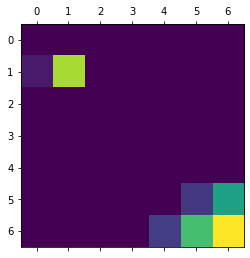

In [13]:
# Generate class activation heatmap
last_conv_layer_name = "block_16_depthwise"
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [14]:
def generate_heatmap(img_path,last_conv_layer_name):
  # Prepare image
  img_size=(224,224)

  img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!

  # Preprocessing the image
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img.astype('float32')/255

  # Remove last layer's softmax
  model.layers[-1].activation = None
  heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

  return heatmap


In [15]:
heatmap =generate_heatmap(img2,"block_16_depthwise")

In [16]:
from IPython.display import Image as imgdisp, display
def save_and_display_gradcam(img_path, heatmap, cam_path="/content/drive/MyDrive/0_data_science/skin_cancer/GradCAM/cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(imgdisp(cam_path))



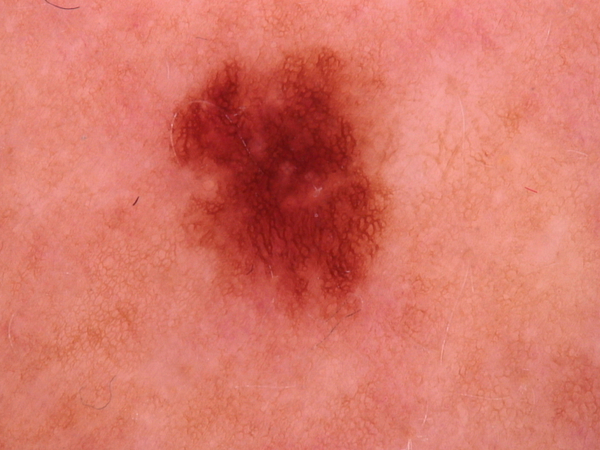

In [30]:
display(imgdisp(img1))

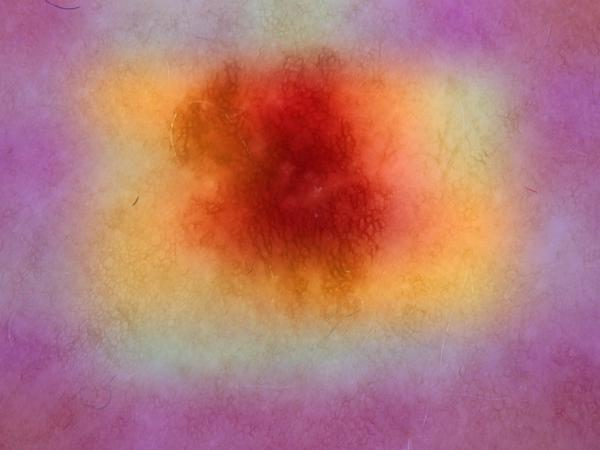

In [31]:
heatmap =generate_heatmap(img1,"block_16_depthwise")
save_and_display_gradcam(img1, heatmap)

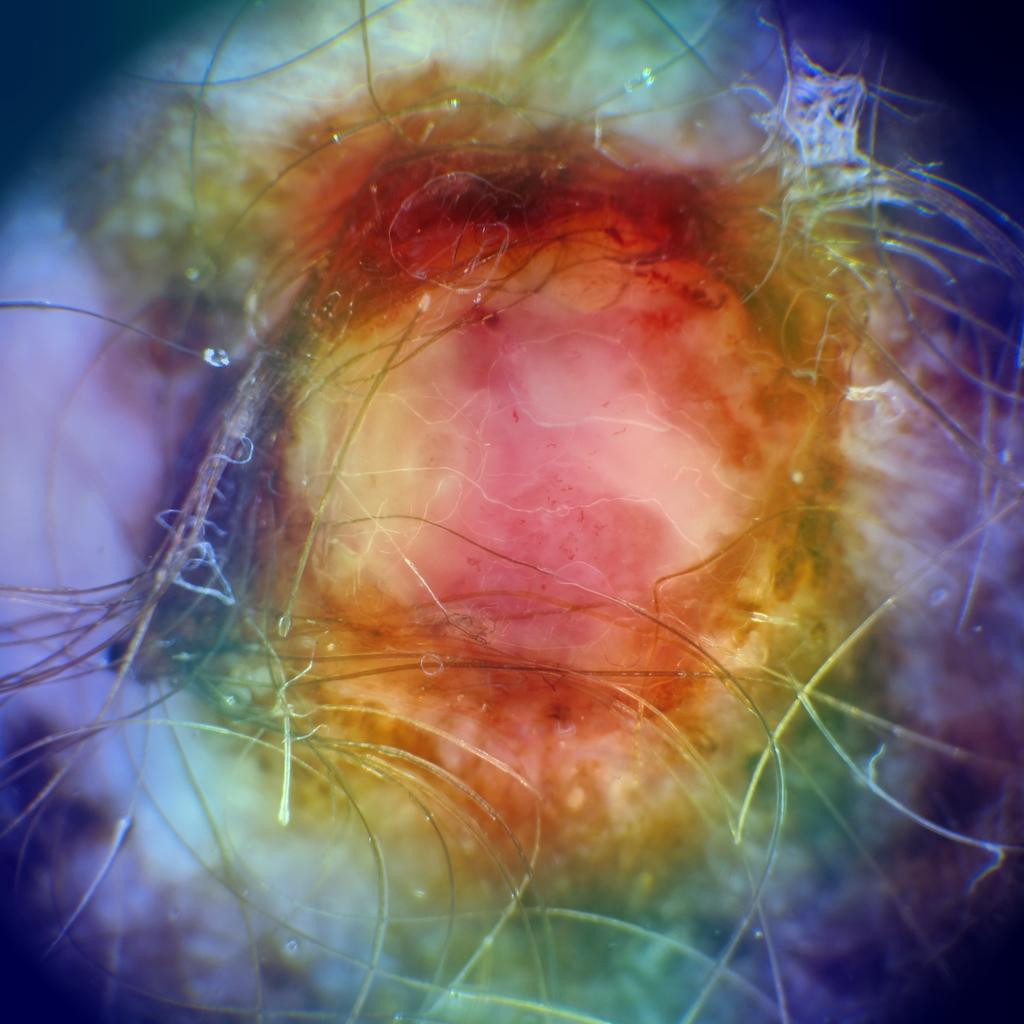

In [19]:
heatmap =generate_heatmap(img2,"block_16_depthwise")
save_and_display_gradcam(img2, heatmap)

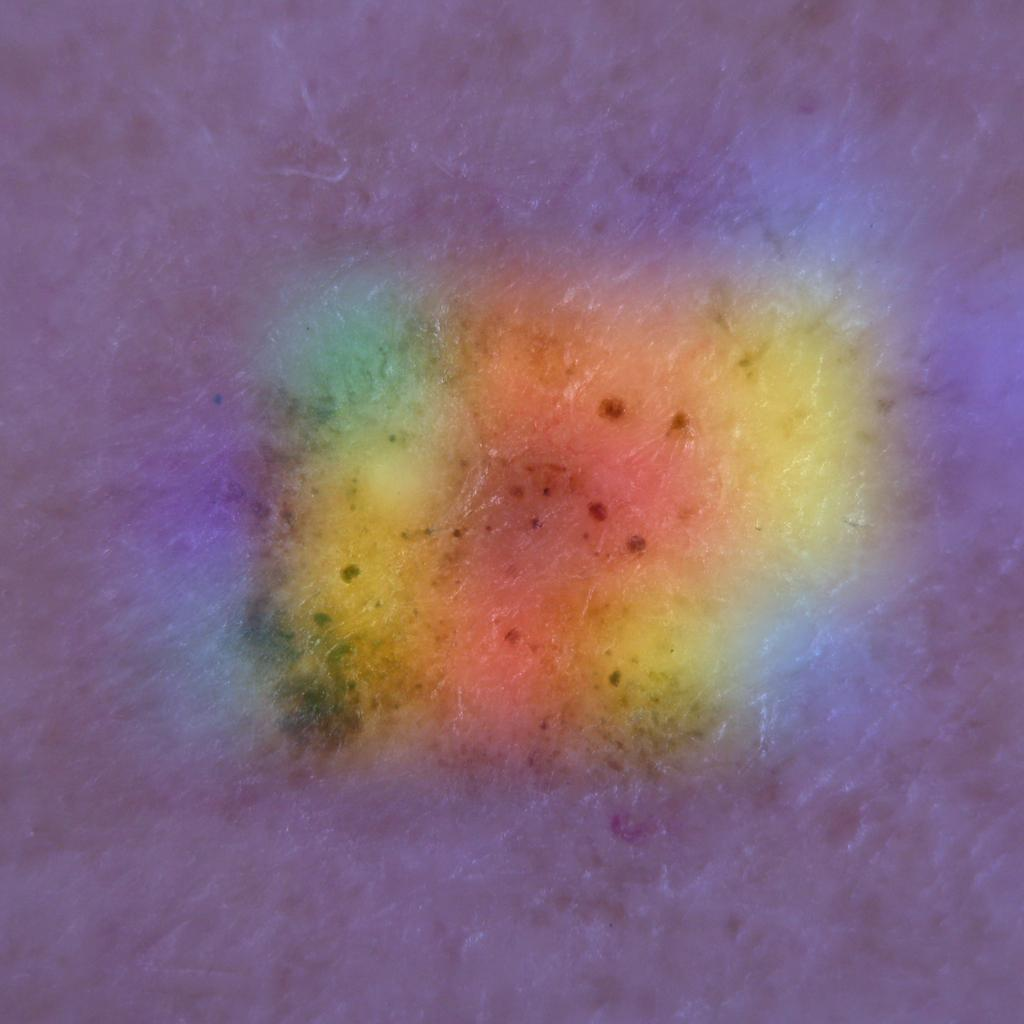

In [20]:
heatmap =generate_heatmap(img3,"block_16_depthwise")
save_and_display_gradcam(img3, heatmap)